# 花卉图像分类实验

本实验主要介绍如何使用MindSpore进行花卉图像分类实验。定义卷积神经网络，并利于该网络进行花卉分类训练和测试。

## 1、实验目的

- 掌握如何使用MindSpore进行卷积神经网络的开发。
- 了解如何使用MindSpore进行花卉图片分类任务的训练。
- 了解如何使用MindSpore进行花卉图片分类任务的测试。

## 2、CNN神经网络原理介绍

本实验采用的是CNN神经网络算法，所以我们首先需要建立初始化的神经网络。

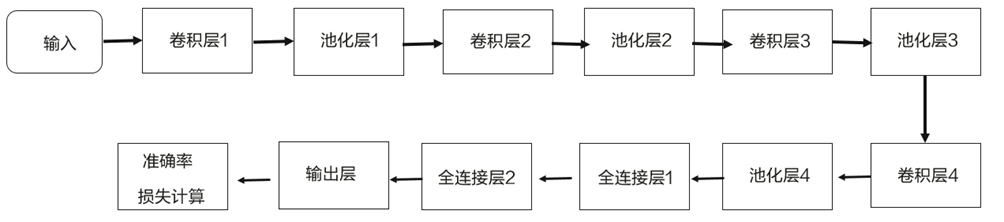

#### 卷积层：

在卷积层计算过程中，输入是一定区域大小(width*height)的数据，和滤波器filter（带着一组固定权重的神经元）做内积后得到新的二维数据。
具体来说，输入图像，然后就是滤波器filter（带着一组固定权重的神经元）进行对应点乘，不同的滤波器filter会得到不同的输出数据，比如颜色深浅、轮廓。如果想提取图像的不同特征，则用不同的滤波器filter，提取想要的关于图像的特定信息：颜色深浅或轮廓。

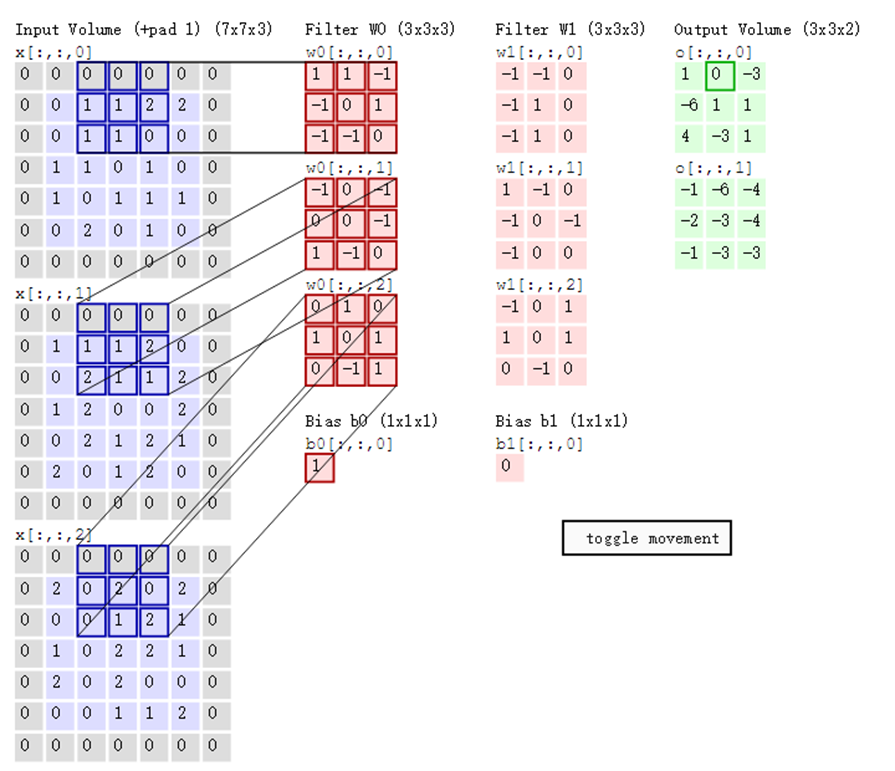

【更多资料】https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

#### 激活函数：

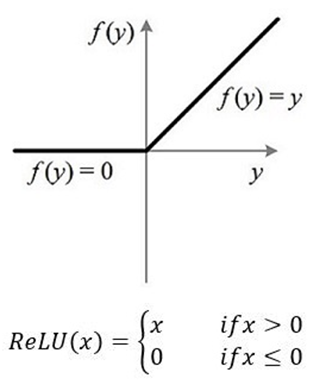

ReLU函数其实是分段线性函数，把所有的负值都变为0，而正值不变，这种操作被称为单侧抑制。正因为有了这单侧抑制，才使得神经网络中的神经元具有了稀疏激活性。尤其体现在深度神经网络模型(如CNN)中，当模型增加N层之后，理论上ReLU神经元的激活率将降低2的N次方倍。

此外，相比于其它激活函数来说，ReLU有以下优势：对于线性函数而言，ReLU的表达能力更强，尤其体现在深度网络中；而对于非线性函数而言，ReLU由于非负区间的梯度为常数1，因此不存在梯度消失问题(Vanishing Gradient Problem)，使得模型的收敛速度维持在一个稳定状态。这里稍微描述一下什么是梯度消失问题：当梯度小于1时，预测值与真实值之间的误差每传播一层会衰减一次，如果在深层模型中使用sigmoid作为激活函数，这种现象尤为明显，将导致模型收敛停滞不前。

#### 池化层：

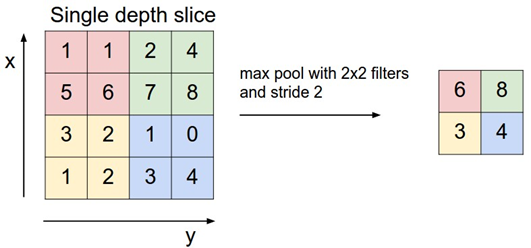

上图所展示的是取区域最大，即上图左边部分中 左上角2x2的矩阵中6最大，右上角2x2的矩阵中8最大，左下角2x2的矩阵中3最大，右下角2x2的矩阵中4最大，所以得到上图右边部分的结果：6 8 3 4。

#### 全连接层：

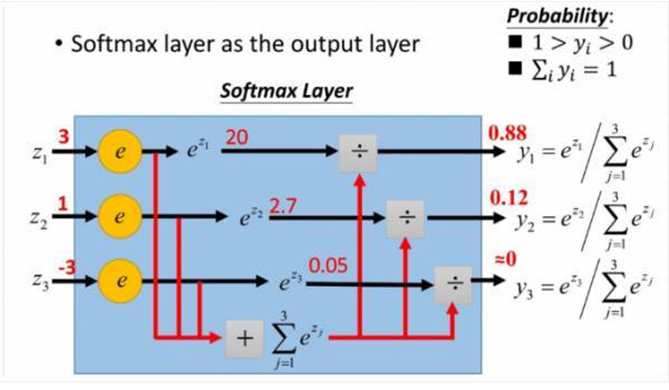

softmax直白来说就是将原来输出是3,1,-3通过softmax函数作用，就映射成为(0,1)的值， 而这些值的累和为1（满足概率的性质），那么我们就可以将它理解成概率， 在最后选取输出结点的时候，我们就可以选取概率最大（也就是值对应最大的）结点，作为我们的预测目标！

## 3、实验环境

本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。

如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

flower_photos共五种鲜花的图片数据，分别为雏菊（daisy ）、蒲公英（dandelion）、玫瑰花（roses）、向日葵(sunflowers)、郁金香（tulips），其中每种约800张图像数据，共计约3670张，可用于深度学习图像分类练习使用，可以在[这里](https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/CANN/flower_photos.zip)下载数据集，并解压到本地。

```
daisy           633张     
dandelion       898张
roses           641张
sunflowers      699张  
tulips          799张
```

In [1]:
from download import download

# 解压数据集，只需要第一次运行时解压，第二次无需再解压
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/CANN/flower_photos.zip"   
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|████████████████████████████| 230M/230M [03:14<00:00, 1.18MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2数据加载

#### 导入MindSpore模块和辅助模块

用到的框架主要包括：MindSpore，主要用于深度学习算法的构建，这里主要用于卷积神经网络的搭建，主要以开源的花类数据集为基础，基于MindSpore深度学习框架和卷积神经网络（CNN）对花的类型进行分类识别。

In [1]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#glob模块主要用于查找符合特定规则的文件路径名，类似使用windows下的文件搜索
import glob
#os模块主要用于处理文件和目录
import os
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision, transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
from mindspore.dataset import vision, transforms
from mindspore.common import dtype as mstype
#导入模块用于初始化截断正态分布
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn, Tensor, ops, load_checkpoint, load_param_into_net
from mindspore.train import ModelCheckpoint, CheckpointConfig, Model

# 设置MindSpore的执行模式和设备
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU") # "Ascend"、“GPU”、“CPU”

#### 变量定义

In [2]:
cfg = edict({
    'data_path': 'flower_photos',
    'data_size': 3670,
    'image_width': 100,            # 图片宽度
    'image_height': 100,           # 图片高度
    'batch_size': 32,
    'channel': 3,                  # 图片通道数
    'num_class': 5,                # 分类类别
    'weight_decay': 0.01,
    'lr': 0.0001,                  # 学习率
    'dropout_ratio': 0.5,
    'epoch_size': 10,              # 训练次数
    'sigma': 0.01,
    
    'save_checkpoint_steps': 1,    # 多少步保存一次模型
    'keep_checkpoint_max': 1,      # 最多保存多少个模型
    'output_directory': './',      # 保存模型路径
    'output_prefix': "checkpoint_classification"  # 保存模型文件名字
})

#### 读取并处理数据

数据读取并处理流程如下：
- MindSpore的mindspore.dataset提供了ImageFolderDataset函数，可以直接读取文件夹图片数据并映射文件夹名字为其标签(label)。这里我们使用ImageFolderDataset函数读取'daisy','dandelion','roses','sunflowers','tulips'数据。并将这五类标签映射为：{'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}
- 使用RandomCropDecodeResize、HWC2CHW、TypeCast进行数据预处理
- 按照8:2的比列将数据划分为训练数据集和测试数据集
- 对训练数据和测试数据分批次（batch）

训练数据集数量： 2912
测试数据集数量： 704
通道数/图像长/宽： (3, 100, 100)
一张图像的标签样式： 0
(100, 100)


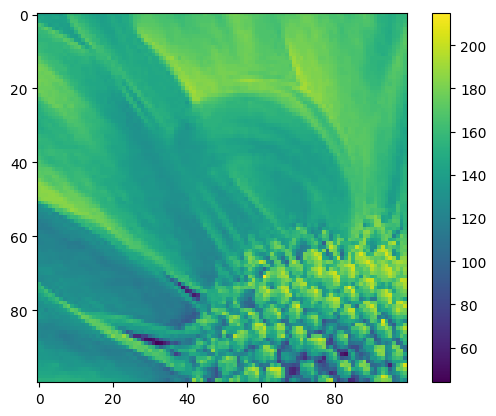

In [3]:
#从目录中读取图像的源数据集。
de_dataset = ds.ImageFolderDataset(cfg.data_path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}, shuffle=False)
trans_transform = [
    #解码前将输入图像裁剪成任意大小和宽高比。
    vision.RandomCropDecodeResize([cfg.image_width,cfg.image_height], scale=(0.08, 1.0), ratio=(0.75, 1.333)),
    #HWC2CHW：将张量格式从NHWC转换成NCHW
    vision.HWC2CHW(),
]
#转换为给定MindSpore数据类型的Tensor操作。
type_cast_op = transforms.TypeCast(mstype.float32)

#将操作中的每个操作应用到此数据集。
de_dataset = de_dataset.map(input_columns="image", operations=trans_transform, num_parallel_workers=4)
de_dataset = de_dataset.map(input_columns="image", operations=type_cast_op, num_parallel_workers=4)

#划分训练集测试集
(de_train,de_test)=de_dataset.split([0.8,0.2], randomize=True)
#设置每个批处理的行数
#drop_remainder确定是否删除最后一个可能不完整的批（default=False）。
#如果为True，并且如果可用于生成最后一个批的batch_size行小于batch_size行，则这些行将被删除，并且不会传播到子节点。
de_train = de_train.batch(cfg.batch_size, drop_remainder=True)
#重复此数据集计数次数。
de_test = de_test.batch(cfg.batch_size, drop_remainder=True)
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size()*cfg.batch_size)
#__next__方法处理后，获取一个batch的数据，数据格式为NCHW，第一维度为batch的数量。
data_next = de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'].shape)
#一共5类，用0-4的数字表达类别。
print('一张图像的标签样式：', data_next['label'])
print(data_next['image'][0,...].shape)

plt.figure()
plt.imshow(data_next['image'][1,...])
plt.colorbar()
plt.grid(False)
plt.show()

## 5、模型构建--定义CNN图像识别网络

In [4]:
# 定义CNN图像识别网络
class Identification_Net(nn.Cell):
    def __init__(self, num_class=5,channel=3,dropout_ratio=0.5,trun_sigma=0.01):  # 一共分五类，图片通道数是3
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel
        self.dropout_ratio = dropout_ratio
        #设置卷积层
        self.conv1 = nn.Conv2d(self.channel, 32,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        #设置ReLU激活函数
        self.relu = nn.ReLU()
        #设置最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2,pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv3 = nn.Conv2d(64, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv4 = nn.Conv2d(128, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma), bias_init='zeros')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(6*6*128, 1024,weight_init =TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.dropout = nn.Dropout(self.dropout_ratio)
        self.fc2 = nn.Dense(1024, 512, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
    #构建模型
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.max_pool2d(x)
        x = self.conv4(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## 6、模型训练、测试

在进行正式的训练和测试之前，需要对模型进行实例化，定义优化器和损失函数，首先简单介绍损失函数及优化器的概念。

损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有SoftmaxCrossEntropyWithLogits、L1Loss、MSELoss等。这里使用SoftmaxCrossEntropyWithLogits损失函数。

MindSpore提供了callback机制，可以在训练过程中执行自定义逻辑，这里使用框架提供的ModelCheckpoint为例。 ModelCheckpoint可以保存网络模型和参数，以便进行后续的fine-tuning（微调）操作。

总共训练10个epoch，每个epoch都需要在训练集上进行运行，并打印出相应的loss值，类似以下代码块的运行结果所示。如果运行在GPU或Ascend平台，epoch可以设置得大一些，以提高模型得预测精度(实验证明：当在Ascend/GPU上训练，epoch_size设置为400时，测试精度可以达到90%左右)。另外，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。 

In [5]:
#实例化网络
net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)

#计算softmax交叉熵，以此作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#设置Adam优化器，将前一步设定的需要更新的参数传入
net_opt = nn.Adam(net.trainable_params(), learning_rate=cfg.lr, weight_decay=0.0)

def train_loop(model, dataset, loss_fn, optimizer):
    # 定义前向传播函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    #获得梯度函数
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    #定义单步训练函数
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 10 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>2d}/{size:>3d}]")

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = cfg.epoch_size
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(net, de_train, net_loss, net_opt)
    ms.save_checkpoint(net, cfg.output_directory+cfg.output_prefix+'-'+str(cfg.epoch_size)+'_'+str(de_train.get_dataset_size())+'.ckpt')
    test_loop(net, de_test, net_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.622697  [ 0/ 91]
loss: 1.584214  [10/ 91]
loss: 1.577616  [20/ 91]
loss: 1.498197  [30/ 91]
loss: 1.461678  [40/ 91]
loss: 1.143085  [50/ 91]
loss: 1.278154  [60/ 91]
loss: 1.200701  [70/ 91]
loss: 1.250216  [80/ 91]
loss: 1.468966  [90/ 91]
Test: 
 Accuracy: 45.3%, Avg loss: 1.293868 

Epoch 2
-------------------------------
loss: 1.285609  [ 0/ 91]
loss: 1.343826  [10/ 91]
loss: 1.176690  [20/ 91]
loss: 1.248252  [30/ 91]
loss: 1.281065  [40/ 91]
loss: 1.242220  [50/ 91]
loss: 1.033666  [60/ 91]
loss: 1.203906  [70/ 91]
loss: 1.337938  [80/ 91]
loss: 1.389794  [90/ 91]
Test: 
 Accuracy: 51.8%, Avg loss: 1.190140 

Epoch 3
-------------------------------
loss: 1.065174  [ 0/ 91]
loss: 1.424579  [10/ 91]
loss: 1.069205  [20/ 91]
loss: 1.140313  [30/ 91]
loss: 1.369842  [40/ 91]
loss: 1.269018  [50/ 91]
loss: 1.187750  [60/ 91]
loss: 0.995799  [70/ 91]
loss: 1.180431  [80/ 91]
loss: 1.061775  [90/ 91]
Test: 
 Accuracy: 55.8%, Avg loss: 1.0

## 7、模型预测

上一步的实验中我们已经设定了模型参数的保存路径，这里就直接加载CKPT文件然后利用模型进行推理。

In [6]:
#加载模型
import os

#实例化网络
net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)
#将参数加载进网络
param_dict = ms.load_checkpoint("./checkpoint_classification-10_91.ckpt")
param_not_load = ms.load_param_into_net(net, param_dict)
#编译整个模型
model = Model(net)
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
#获取测试集的batch
test_ = de_test.create_dict_iterator().__next__()
#转换为tensor
test = Tensor(test_['image'], ms.float32)
#预测
predictions = model.predict(test)
predictions = predictions.asnumpy()
true_label = test_['label'].asnumpy()

#显示预测结果
for i in range(9):
    p_np = predictions[i, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '真实结果：',class_names[true_label[i]])

第0个sample预测结果： roses 真实结果： roses
第1个sample预测结果： roses 真实结果： roses
第2个sample预测结果： dandelion 真实结果： dandelion
第3个sample预测结果： dandelion 真实结果： dandelion
第4个sample预测结果： dandelion 真实结果： tulips
第5个sample预测结果： sunflowers 真实结果： dandelion
第6个sample预测结果： dandelion 真实结果： dandelion
第7个sample预测结果： sunflowers 真实结果： sunflowers
第8个sample预测结果： sunflowers 真实结果： sunflowers
